# Forecasting Hourly based energy consumption

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error

plt.style.use('fivethirtyeight')
color_pal = sns.color_palette()

In [2]:
url = '../input/hourly-energy-consumption/PJME_hourly.csv'
df = pd.read_csv(url)
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

In [3]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


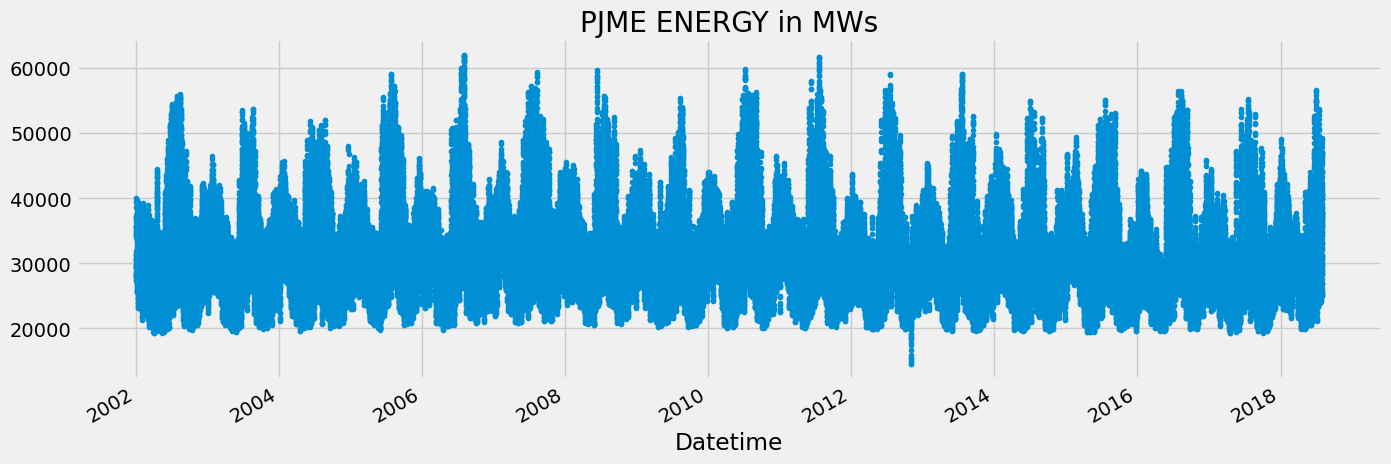

In [4]:
df.plot(style='.', figsize=(15,5),
        color=color_pal[0],
        title='PJME ENERGY in MWs', legend=False)
plt.show()

## Train/Test Split

In [5]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index > '01-01-2015']

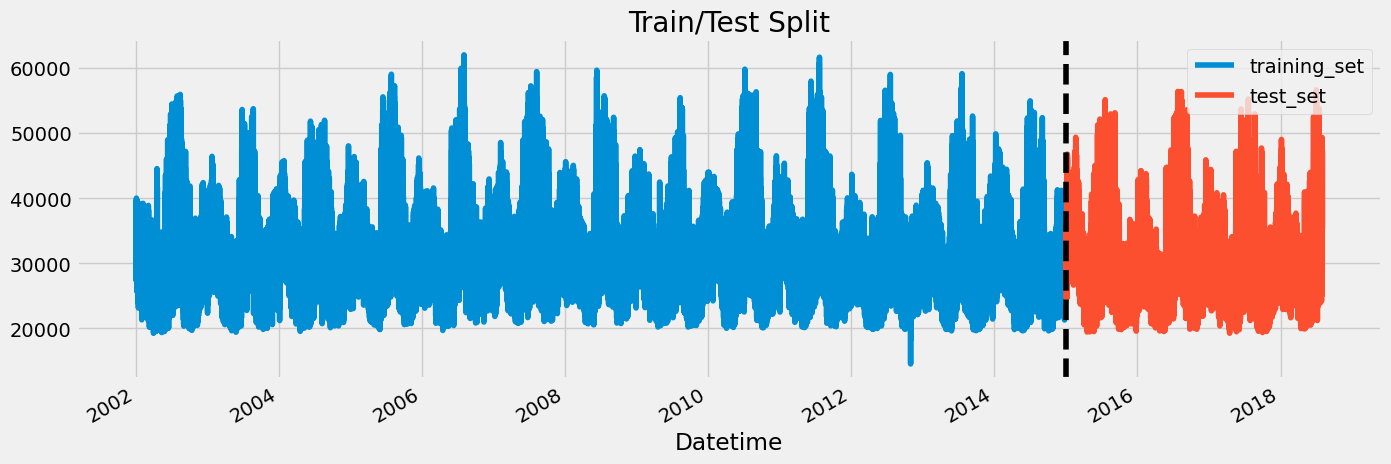

In [6]:
fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, title = 'Train/Test Split', label='train_MWs')
test.plot(ax=ax, label='Test_MWs')
ax.axvline('01-01-2015', color = 'black', ls='--')
ax.legend(['training_set', 'test_set'])

plt.show()

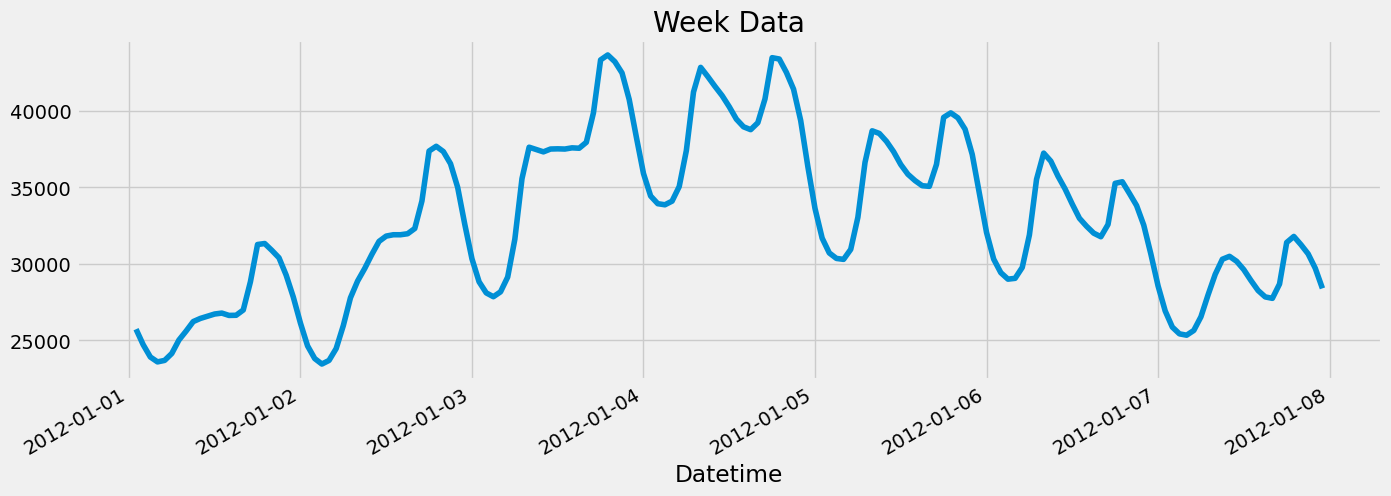

In [7]:
df.loc[(df.index > '01-01-2012') & (df.index < '01-08-2012')].plot(figsize=(15,5), title='Week Data', legend=False)
plt.show()

## Feature Creation

In [8]:
def create_features(df):
    '''
    Create time series features using time series index. 
    '''
    
    df = df.copy()
    df['Hour'] = df.index.hour
    df['DayOfWeek'] = df.index.dayofweek
    df['Quarter'] = df.index.quarter
    df['Month'] = df.index.month
    df['Year'] = df.index.year
    df['Dayofyear'] = df.index.dayofyear
    return df

In [9]:
df = create_features(df)
df.head()

,PJME_MW,Hour,DayOfWeek,Quarter,Month,Year,Dayofyear
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365


## Visualize features

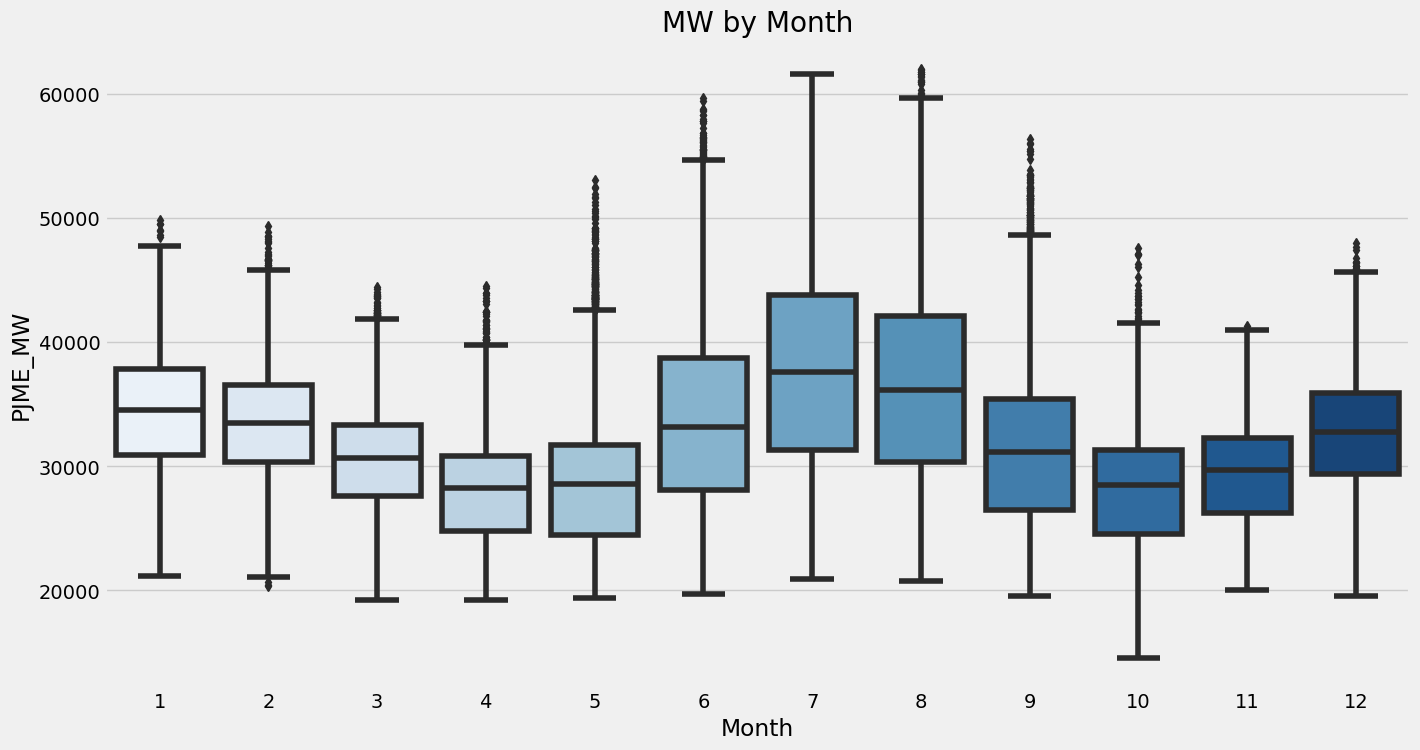

In [10]:
fig, ax = plt.subplots(figsize=(15,8))
sns.boxplot(data=df, x='Month', y='PJME_MW',palette='Blues')
ax.set_title('MW by Month')
plt.show()

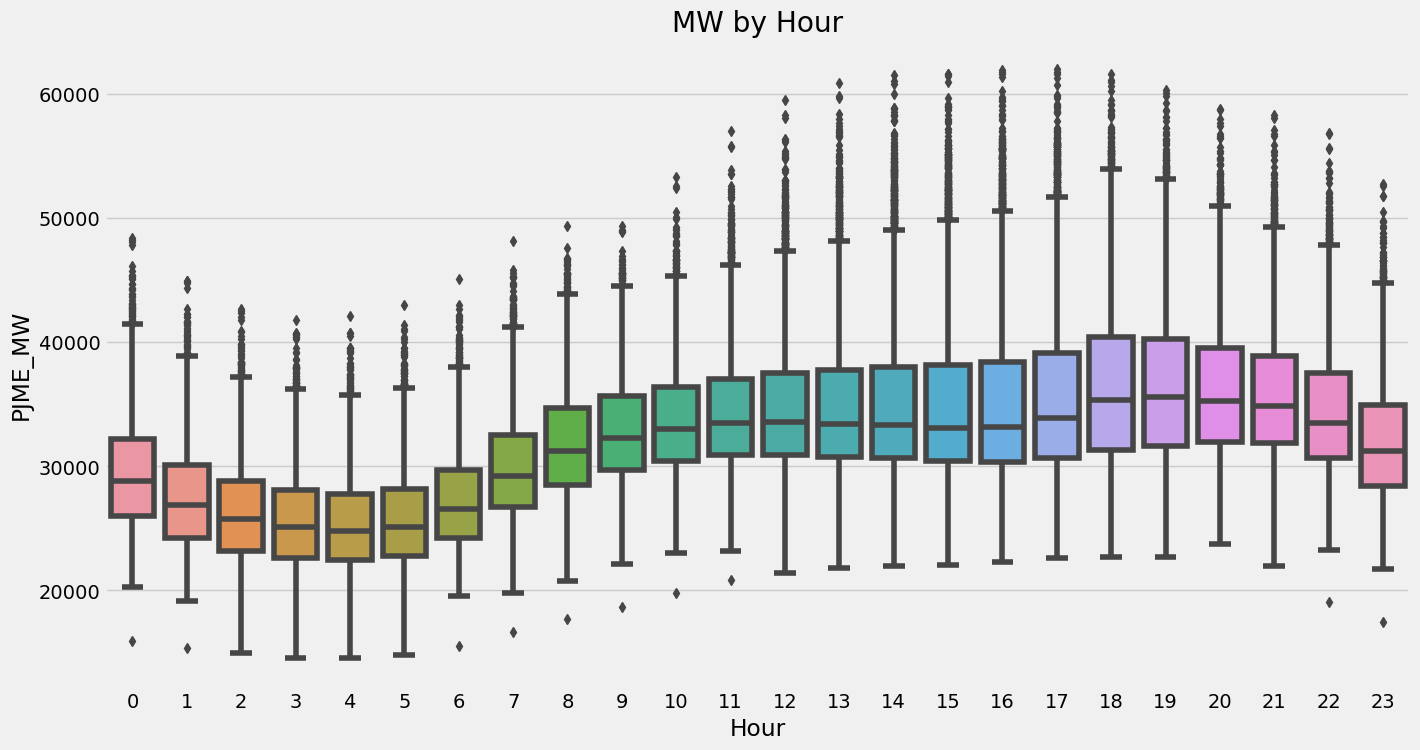

In [11]:
fig, ax = plt.subplots(figsize=(15,8))
sns.boxplot(data=df, x='Hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

## Create Model

In [12]:
train = create_features(train)
test = create_features(test)

feature = ['Hour', 'DayOfWeek', 'Quarter', 'Month', 'Year', 'Dayofyear']
target = ['PJME_MW']

x_train = train[feature]
y_train = train[target]

x_test = test[feature]
y_test = test[target]

regression_m = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.01)
regression_m.fit(x_train, y_train,
                eval_set = [(x_train, y_train), (x_test, y_test)],
                verbose=100)

[0]	validation_0-rmse:32601.87826	validation_1-rmse:31654.26256
[100]	validation_0-rmse:12342.13873	validation_1-rmse:11517.61218
[200]	validation_0-rmse:5373.33346	validation_1-rmse:5165.29889
[300]	validation_0-rmse:3375.20923	validation_1-rmse:3829.29864
[400]	validation_0-rmse:2882.55200	validation_1-rmse:3715.10548
[437]	validation_0-rmse:2793.31200	validation_1-rmse:3727.21854


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

## Feature Importance

In [13]:
fi = pd.DataFrame(data=regression_m.feature_importances_,
                  index=regression_m.feature_names_in_,
                  columns=['Importance'])

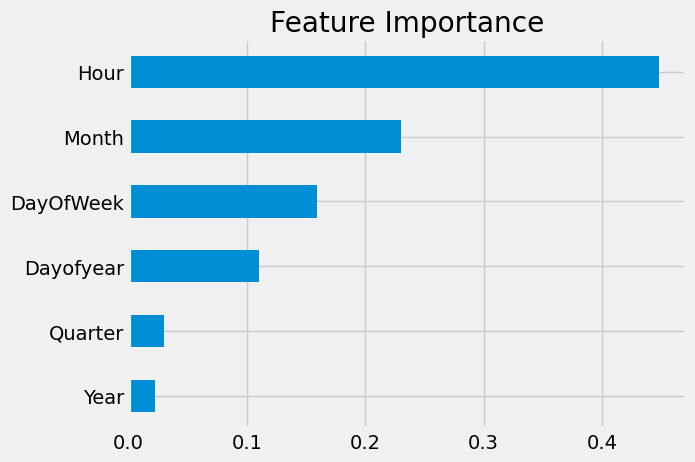

In [14]:
fi.sort_values(['Importance']).plot(kind='barh', title='Feature Importance', legend=False)
plt.show()

## Forecast on test

In [15]:
test['prediction'] = regression_m.predict(x_test)
df = df.merge(test[['prediction']], how='left', right_index=True, left_index=True)
df

,PJME_MW,Hour,DayOfWeek,Quarter,Month,Year,Dayofyear,prediction
Datetime,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,NaN
...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,41014.218750
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,40507.140625
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,38933.621094


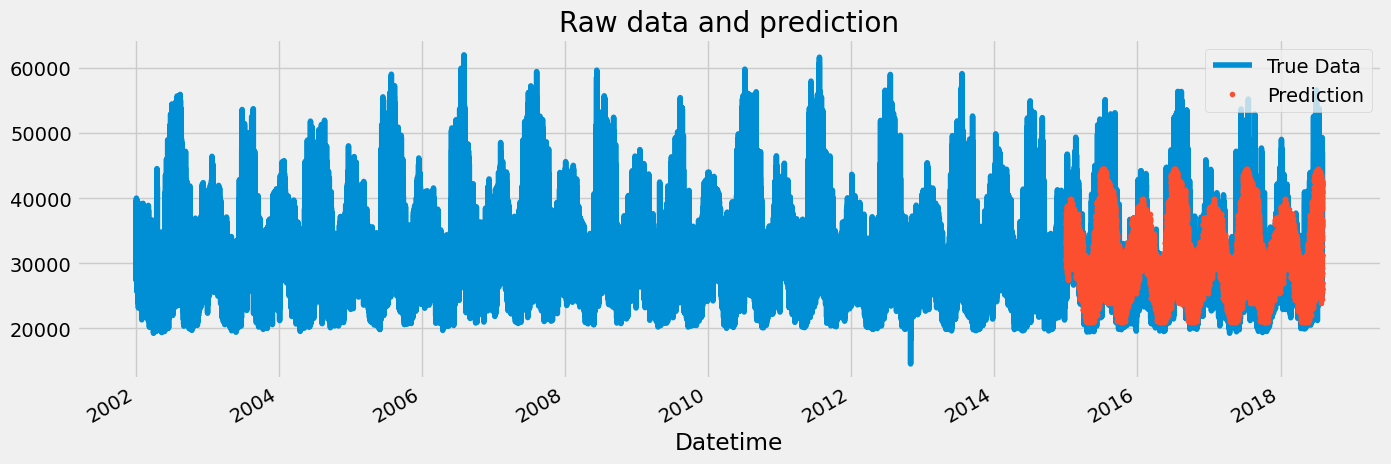

In [16]:
ax = df[['PJME_MW']].plot(figsize=(15,5))
df['prediction'].plot(ax=ax, style='.')
ax.set_title('Raw data and prediction')
plt.legend(['True Data', 'Prediction'])
plt.show()

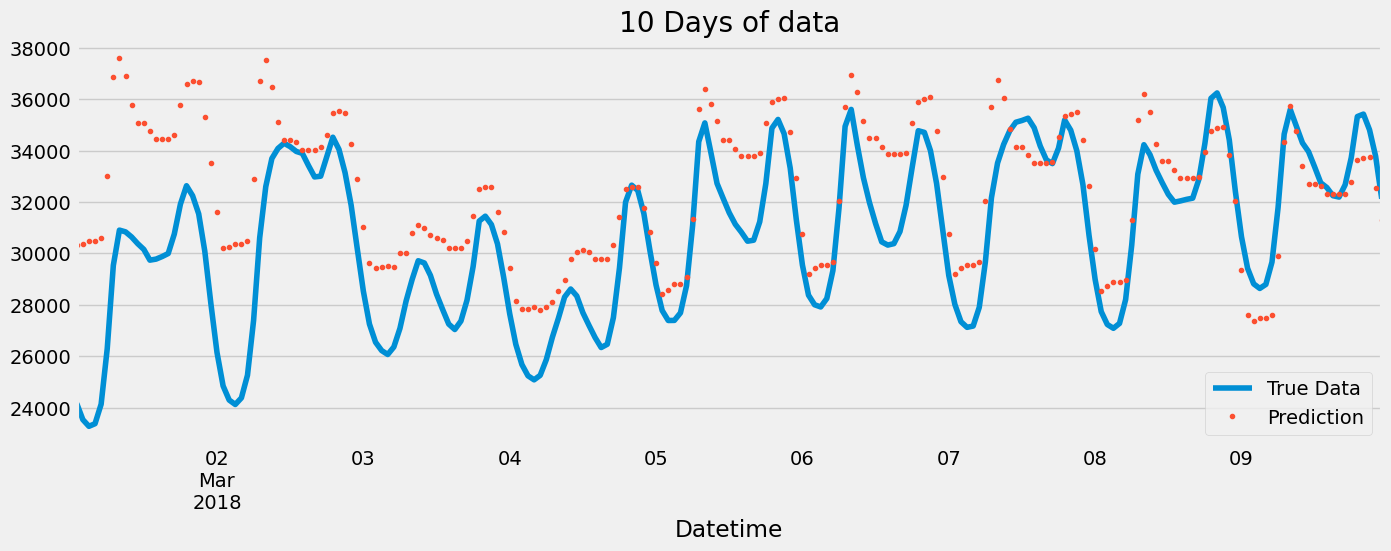

In [17]:
ax = df.loc[(df.index > '03-01-2018') & (df.index < '03-10-2018')]['PJME_MW'] \
.plot(figsize=(15,5), title='10 Days of data')
df.loc[(df.index > '03-01-2018') & (df.index < '03-10-2018')]['prediction'].plot(ax=ax, style='.')
plt.legend(['True Data', 'Prediction'])
plt.show()

## Test Prediction RSME

In [18]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE score on Test set: {score:0.2f}')

RMSE score on Test set: 3714.59


## Calculate Error (True value -  prediction value)

In [19]:
test['error'] = np.abs(test['PJME_MW'] - test['prediction'])
test['date'] = test.index.date

In [20]:
test.groupby('date')['error'].mean().sort_values(ascending=False).head()

date
2016-08-13    14559.813965
2016-08-14    14393.350911
2016-09-10    12564.790202
2016-08-12    11527.895264
2016-09-09    11432.962240
Name: error, dtype: float64

In [21]:
test.groupby('date')['error'].mean().sort_values(ascending=True).head()

date
2016-09-27    376.074544
2016-05-01    420.460286
2016-04-04    432.775065
2015-03-10    444.994792
2016-12-08    480.121663
Name: error, dtype: float64